# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


# Install detectron2

In [2]:
# install dependencies: 
!pip install pyyaml==5.1 'pycocotools>=2.0.1'
#!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
#!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 9.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=2282fc2256a2c8341c8bcefb40c4b7ffb9a05e77f01c2f64e31c8a663b17cd9b
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True


In [3]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 5.7MB/s 
     |████████████████████████████████| 2.2MB 11.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201111-cp36-none-any.whl size=44418 sha256=de9cc5456672e29bcc093f1aae0b8d00cee12437cc44ff826b8c63bc801bec33
  Stored in directory: /root/.cache/pip/wheels/70/d9/52/49a17f0d21e723c371c4a3f60138545e0a4163c5f7ff42c855
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def load_sem_seg(gt_root, image_root, gt_ext="png", image_ext="jpg"):
    """
    Load semantic segmentation datasets. All files under "gt_root" with "gt_ext" extension are
    treated as ground truth annotations and all files under "image_root" with "image_ext" extension
    as input images. Ground truth and input images are matched using file paths relative to
    "gt_root" and "image_root" respectively without taking into account file extensions.
    This works for COCO as well as some other datasets.

    Args:
        gt_root (str): full path to ground truth semantic segmentation files. Semantic segmentation
            annotations are stored as images with integer values in pixels that represent
            corresponding semantic labels.
        image_root (str): the directory where the input images are.
        gt_ext (str): file extension for ground truth annotations.
        image_ext (str): file extension for input images.

    Returns:
        list[dict]:
            a list of dicts in detectron2 standard format without instance-level
            annotation.

    Notes:
        1. This function does not read the image and ground truth files.
           The results do not have the "image" and "sem_seg" fields.
    """

    # We match input images with ground truth based on their relative filepaths (without file
    # extensions) starting from 'image_root' and 'gt_root' respectively.
    def file2id(folder_path, file_path):
        # extract relative path starting from `folder_path`
        image_id = os.path.normpath(os.path.relpath(file_path, start=folder_path))
        # remove file extension
        image_id = os.path.splitext(image_id)[0]
        return image_id

    input_files = sorted(
        (os.path.join(image_root, f) for f in PathManager.ls(image_root) if f.endswith(image_ext)),
        key=lambda file_path: file2id(image_root, file_path),
    )
    gt_files = sorted(
        (os.path.join(gt_root, f) for f in PathManager.ls(gt_root) if f.endswith(gt_ext)),
        key=lambda file_path: file2id(gt_root, file_path),
    )

    assert len(gt_files) > 0, "No annotations found in {}.".format(gt_root)

    # Use the intersection, so that val2017_100 annotations can run smoothly with val2017 images
    if len(input_files) != len(gt_files):
        logger.warn(
            "Directory {} and {} has {} and {} files, respectively.".format(
                image_root, gt_root, len(input_files), len(gt_files)
            )
        )
        input_basenames = [os.path.basename(f)[: -len(image_ext)] for f in input_files]
        gt_basenames = [os.path.basename(f)[: -len(gt_ext)] for f in gt_files]
        intersect = list(set(input_basenames) & set(gt_basenames))
        # sort, otherwise each worker may obtain a list[dict] in different order
        intersect = sorted(intersect)
        logger.warn("Will use their intersection of {} files.".format(len(intersect)))
        input_files = [os.path.join(image_root, f + image_ext) for f in intersect]
        gt_files = [os.path.join(gt_root, f + gt_ext) for f in intersect]

    logger.info(
        "Loaded {} images with semantic segmentation from {}".format(len(input_files), image_root)
    )

    dataset_dicts = []
    for (img_path, gt_path) in zip(input_files, gt_files):
        record = {}
        record["file_name"] = img_path
        record["sem_seg_file_name"] = gt_path
        dataset_dicts.append(record)

    return dataset_dicts


In [7]:
from fvcore.common.file_io import PathManager
import logging
logger = logging.getLogger(__name__)

#datalabels=load_sem_seg(annotations, images_dir, gt_ext="png", image_ext="png")


##images_dir = "/content/drive/My Drive/CIS581/FinalProject/Kitti/train_images/image_2"
#annotations="/content/drive/My Drive/CIS581/FinalProject/Kitti/trainingmask/"

images_dir = "/content/drive/My Drive/CIS581/FinalProject/bdd/bdd100k/seg/images/train/"
annotations="/content/drive/My Drive/CIS581/FinalProject/bdd/bdd100k/seg/labels/train/"
json_fileloc="/content/drive/My Drive/CIS581/FinalProject/bdd/training_corrected_1000v2.json"

In [8]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train5", {}, "/content/drive/My Drive/CIS581/FinalProject/bdd/training_corrected_1000v2.json",images_dir)



In [9]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "/content/drive/My Drive/CIS581/FinalProject/bdd/training_corrected_1000v2.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

WARNING [11/18 00:56:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/18 00:56:08 d2.data.datasets.coco]: Loaded 999 images in COCO format from /content/drive/My Drive/CIS581/FinalProject/bdd/training_corrected_1000v2.json
filename= /content/drive/My Drive/CIS581/FinalProject/bdd/bdd100k/seg/images/train/0d5b19b3-fe488e51.jpg


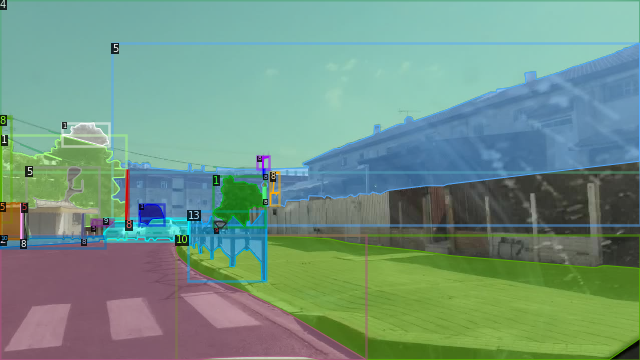

filename= /content/drive/My Drive/CIS581/FinalProject/bdd/bdd100k/seg/images/train/0bf18a00-e8c3335e.jpg


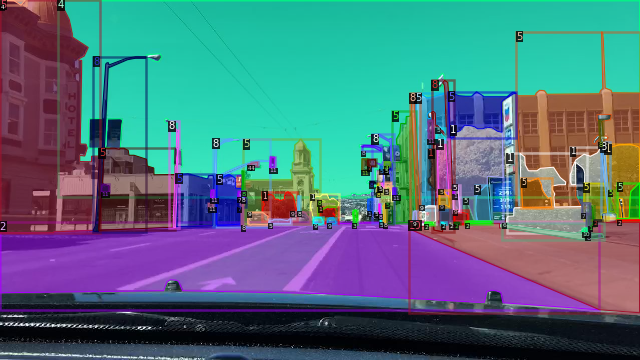

filename= /content/drive/My Drive/CIS581/FinalProject/bdd/bdd100k/seg/images/train/0f442be6-6b658bbe.jpg


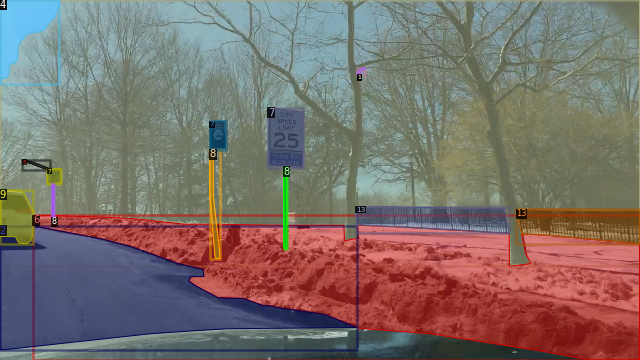

In [10]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train5")
dataset_dicts = DatasetCatalog.get("my_dataset_train5")
import random
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 3):
    print("filename=",d["file_name"])
    img = cv2.imread(d["file_name"])

    #print("filename=","/content/drive/My Drive/CIS581/FinalProject/bdd/bdd100k/seg/images/train/5421185a-fbbb8f7f.jpg")
    #img = cv2.imread("/content/drive/My Drive/CIS581/FinalProject/bdd/bdd100k/seg/images/train/5421185a-fbbb8f7f.jpg")
    visualizer = Visualizer(img[:, :, ::-1], scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])
    #cv2_imshow(img)

In [11]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train5",)
cfg.DATASETS.TEST = ()#"my_dataset_val3",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")#"COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")   #"COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001  #0.00025  # pick a good LR

cfg.SOLVER.WARMUP_ITERS=100
cfg.SOLVER.MAX_ITER = 350   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset

#cfg.SOLVER.STEPS=(10,15)
#cfg.SOLVER.GAMMA=0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64 #128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

#cfg.TEST.EVAL_PERIOD=500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/18 00:56:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (15, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (56, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (56,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (14, 256, 1, 

[11/18 00:56:27 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python

[11/18 00:56:48 d2.utils.events]:  eta: 0:05:59  iter: 19  total_loss: 5.849  loss_cls: 2.547  loss_box_reg: 0.5771  loss_mask: 0.6897  loss_rpn_cls: 1.165  loss_rpn_loc: 0.8586  time: 1.0832  data_time: 0.0462  lr: 0.00019081  max_mem: 4816M
[11/18 00:57:11 d2.utils.events]:  eta: 0:05:43  iter: 39  total_loss: 3.431  loss_cls: 1.172  loss_box_reg: 0.5189  loss_mask: 0.6655  loss_rpn_cls: 0.299  loss_rpn_loc: 0.7709  time: 1.1069  data_time: 0.0145  lr: 0.00039061  max_mem: 4816M
[11/18 00:57:34 d2.utils.events]:  eta: 0:05:26  iter: 59  total_loss: 3.494  loss_cls: 1.095  loss_box_reg: 0.6666  loss_mask: 0.6378  loss_rpn_cls: 0.28  loss_rpn_loc: 0.8166  time: 1.1196  data_time: 0.0143  lr: 0.00059041  max_mem: 4816M
[11/18 00:57:56 d2.utils.events]:  eta: 0:05:02  iter: 79  total_loss: 3.195  loss_cls: 1.004  loss_box_reg: 0.6674  loss_mask: 0.5957  loss_rpn_cls: 0.227  loss_rpn_loc: 0.7522  time: 1.1184  data_time: 0.0203  lr: 0.00079021  max_mem: 4816M
[11/18 00:58:18 d2.utils.even

In [12]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [13]:
import time
from detectron2.utils.visualizer import ColorMode

import matplotlib.pyplot as plt
import matplotlib as mpl

In [15]:
#pip install threading
import logging
import threading
import time

In [49]:
def threading_funct(frame):
  outputs = predictor(frame) 
  data=outputs["instances"].to("cpu")
  output_mask=data.pred_masks.numpy().astype(int)
  output_classes=data.pred_classes.numpy()
  count=output_classes.shape
  mask=output_mask*output_classes[:,np.newaxis, np.newaxis]
  newimage1=np.amax(mask,axis=0)
 
  global newimage
  newimage=newimage1
  global ready
  ready=True

starttime=time.time()
print("set video fps before running this code")
print("Code may fail on first run, if this happens try running again.")
fps=29.97
print("fps=",fps)


video=cv2.VideoCapture('480_360vid.mp4')


frame_width = int(video.get(3)*2) 
frame_height = int(video.get(4)) 
   
size = (frame_width, frame_height) 
output=cv2.VideoWriter("/content/drive/My Drive/CIS581/FinalProject/480_360_Video_compare_color_.mp4",  
                         cv2.VideoWriter_fourcc(*'Mp4V'), 
                         fps, size)
ready=True
counter=0
while(True):
  t=time.time()
  
  ret,frame=video.read()

  if ret==True:
    if ready==True:
      if counter==0:
        outputim=frame
      ready=False
      x=threading.Thread(target=threading_funct, args=(frame,) )
      x.start()   
    else:
      if counter==0:
        outputim=frame
      else:  
        outputim=(newimage*25).astype(np.uint8)
        outputim=cv2.cvtColor(outputim, cv2.COLOR_RGB2BGR)
        outputim=cv2.applyColorMap(outputim,cv2.COLORMAP_JET)  

    outputimage=cv2.hconcat([frame,outputim])
    output.write(outputimage)
    counter=1
    timediff=time.time()-t

    if timediff < (1/fps):
     time.sleep((1.0/fps)-timediff)

  else:
    break
  

video.release()
output.release()
print("total Time=",time.time()-starttime)
print("Must check length of original video, if length is longer than")
print("total time, the program did not run in real time.")

set video fps before running this code
Code may fail on first run, if this happens try running again.
fps= 29.97
total Time= 40.4803102016449
Must check length of original video, if length is longer than
total time, the program did not run in real time.
